<a href="https://colab.research.google.com/github/carinunez/Tareas_generativos/blob/main/Tarea1_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 1: Modelos Autorregresivos

### MDS7203 Modelos Generativos Profundos

**Nombre:**
- Carolina Nuñez
- Hecmar Taucare

**Fecha de entrega:**

Dado que la arquitectura Transformer es una de las dos arquitecturas específicas que se verán a lo largo del curso (la otra es la arquitectura U-Net), es importante asegurarse de entenderla bien. Por este motivo, esta primera tarea tendrá varias preguntas conceptuales que buscan evaluar si se entienden bien algunos detalles importantes de la arquitectura Transformer.

Algunas instrucciones generales:
- Se pueden utilizar de manera libre herramientas como ChatGPT y Claude, entre otras.
- Para la entrega, no es necesario un informe, este archivo es suficiente.
- Se debe entregar el documento con todas las celdas ejecutadas.
- Se recomienda correr la tarea en GPU (usando Google Colab o una GPU local).
- La tarea tiene 3 partes, y cada parte vale lo mismo.

## Parte 1 (preguntas conceptuales)

### Modelos autorregresivos generales
- ¿Qué son los tokens especiales dentro de un vocabulario? Nombre al menos 5 junto a su función.
> **Respuesta:**
  Tokens especiales: son tokens añadidos durante el proceso de tokenización para cumplir un a función en particular, y son utilizados como marcadores.
  1. **\<PAD>** : utilizado como "relleno", para forzar el largo de una secuencia cuando no se logra el tamaño adecuado.
  2. **\<BOS>** : token agregado al inicio de cada secuencia
  3. **\<EOS>** : token agregado al final de cada secuencia
  4. **\<UNK>** : utilizado para representar tokens desconocidos,ie. fuera del vocabulario extendido.
  5. **\<MASK>** : utilizado para enmascarar/tapar un token. Se suele utilizar en BERT.

- Los modelos autorregresivos se entrenan siguiendo el enfoque de máxima verosimilitud. Sin embargo, durante el entrenamiento, es usual normalizar la verosimilitud de una secuencia por su largo, ¿por qué se hace esto?
> **Respuesta:**
Como la log verosimilitud se define como una suma, las secuencias de mayor longitud dominarían esta función, entonces para evitar este problema se normaliza por el largo de la secuencia, dándoles igual importancia a todas las secuencias. De esa forma, si tengo dos respuestass correctas a una pregunta (una corta y otra larga), normalizar hace que estas sean igual de buenas para el modelo, sin priorizar una por sobre otra. Pues si no normalizo, la respuesta larga se tiene mayor función de pérdida por tener más tokens.


- ¿Por qué los modelos neuronales por lo general no aplican la función Softmax en la salida, incluso cuando se está buscando aprender un vector de probabilidades (que permite definir una distribución sobre el vocabulario para predecir el siguiente token)? ¿Cómo se relaciona esto con la idea de temperatura usada durante la inferencia?
> **Respuesta:**
  No se suele aplicar la función Softmax, pues esta se incluye de forma implícita dentro de la función de pérdida Cross Entropy, que toma los logits  y aplica softmax para luego calcular la función de pérdida.

  Además aplicarla en la salida sería redundante y podría generar inestabilidades. Es por esto que nacen ciertas medidas de normalización, tanto para mejorar la estabilidad del modelo como para tener una salida de probabilidad más flexible, una de ellas es la temperatura:
  - Baja temperatura *(T<1)* : la distribución de prob de los tokens tiene poca dispersión, por lo que los tokens de mayor prob suelen ser los escogidos.
  - Alta temperatura *(T>1)* : al distribución se vuelve cada vez más homogénea, por lo que se le termina dando más peso a los tokens menos probables. Esto le da mayor "creatividad" al modelo para elegir tokens.

   <!-- en la cual a menor valor de temperatura *(T<1)*  se seleccionaran las secuencias que mayor probabilidad tienen de ser las correctas dadas las secuencias anteriores (menor dispersión en la distribución de tokens) , es decir el top de las mejores. Mientras que con mayor temperatura *(T>1)* se le da mayor "creatividad" al modelo para elegir secuencias secundarias *(mayor dispersión en la probabilidad de tokens)*, pero que son buenas respuestas. -->
   Además, no aplicar la softmax resulta más eficiente y estable, sino en la optimización el modelo podría explotar o no converger a un mínimo local.


- ¿Cuál es la función de la temperatura al generar secuencias? ¿Qué diferencia hay entre una temperatura alta y una temperatura baja?
> **Respuesta:**
  La **temperatura** es un parámetro que ajusta la aleatoriedad de las predicciones del modelo durante la generación de texto. Se aplica a los *logits* antes de convertirlos a dist de prob

  $$
  P_i = \frac{e^{z_i / T}}{\sum_j e^{z_j / T}}
  $$

  Donde:

  - $( z_i )$: logit del token \( i \)  
  - $( T)$: temperatura (escala)  
  - $( P_i)$: probabilidad del token \( i \)

  **Interpretación del efecto de T:**

  - Si \( T = 1 \), se usa softmax normal.  
  - Si \( T < 1 \), la distribución se vuelve más “picuda” → más determinismo. Se le da mayor peso a los tokens más probables al ser más concentrada.
  - Si \( T > 1 \), la distribución se aplana → más creatividad. Se le da más peso a los tokens menos probables, por lo que aumenta la aleatoriedad en las respuestas.

<!-- La temperatura permite controlar que tan creativas o precisas serán las secuencias creadas en la inferencia. Una temperatura alta le dará similar probabilidad a todos los tokens suavizando la distribución, mientras que una temperatura baja es bastante determinista pues se le da mayor peso a los tokens con mayor probabilidad *(concentrando o dandole mas peso a las secuencias que por si son las más probables de ser las mejores de todas)*, por lo que, en solicitudes de hacer poemas por ejemplo:
La temperatura alta servirá para ajustar la respuesta al elegir secuencias secundarias -> mayor creatividad en labores artísticas.
Mientras que para labores matemáticas el modelo tendrá la mejor solución posible a temperatura baja, dado que la matemática posee una lógica subyacente que es inalterable en la mayoria de los casos, tendiendo a una solución determinista -->


### Arquitectura GPT
- ¿Por qué se proyecta una misma entrada en 3 matrices ($Q$, $K$ y $V$) para el cálculo de atención? ¿Por qué no usar la propia entrada como vectores de query, key y value?
> **Respuesta:**
  Las 3 proyecciones entregan distinta info acerca de los tokens entregados. Esto permite que los tokens sean capaces de poner atención a otros tokens y cuantificarla. Entonces, al multiplicarlas es posible obtener relaciones entre tokens y se fuerza a que el modelo aprenda de la información en otra dimensión.
  Al paralelizar lo anterior y usar varias capas de Self-Attention, el modelo puede aprender diferentes habilidades, tales como reconocer estructuras gramaticales, operaciones lógicas, formas en las que se relacionan las palabras y formas de responder.

  <!-- La matriz Q representa al token actual, K los tokens a los que se les presta atención y V la info que entrega el token. Entonces, al multiplicarlas es posible obtener relaciones entre tokens y se fuerza a que el modelo aprenda de la información en otra dimensión.
  Al paralelizar lo anterior y usar varias capas de selfattention, el modelo puede aprender diferentes habilidades, tales como reconocer estructura gramatical, operaciones lógicas, formas en las que se relacionan las palabras y formas de responder

  Antes de explicar lo anterior cabe destacar de que cada una de las matrices inician con pesos aleatorios, porque si fueran la misma matriz el modelo aprendería lo mismo. Cada una de estas posee cierta labor dentro del aprendizaje tanto del contexto de los tokens dentro del vocabulario, como la relación entre los tokens. Al multiplicar las matrices entre ellas,las cuales son resultado de entre ellas *(utilizando el producto punto como medida de similitud,)*, se pueden observar relaciones entre tokens y al multiplicar las matrices se fuerza a que el modelo aprenda de la información en otra dimensión (proyección), distintas proyecciones implican diferentes relaciones y puntos de vista diferentes, al paralelizar lo anterior y usar varias capas de selfattention, el modelo puede aprender diferentes habilidades, tales como reconocer estructura gramatical, operaciones lógicas, formas en las que se relacionan las palabras y formas de responder.. -->

  En particular, la Atención se calcula de la siguiente forma:
  $$
  \text{Attention}(Q, K, V) = \text{softmax} \left( \frac{Q K^\top}{\sqrt{p}} \right) \cdot V
  $$

  Las tres matrices anteriores corresponden cada una a
  - Q Query(matriz de consulta)
  - K Key (clave)
  - V Value (valor)
  El producto punto entre Q y K permite medir la similitud entre tokens, y con eso se calcula qué tan relevante es cada token con respecto a los demás. Este resultaso se pondera por los valores en V, permitiendo al modelo enfocarse directamente forma dinámica a aprender en diferentes partes de la secuencia de forma paralela.
  <!-- Estas distintas proyecciones hacen que el modelo aprenda relaciones desde múltiples puntos de vista (gramática, sintaxis, semántica, etc.), especialmente cuando se usan múltiples cabezas de atención en paralelo. -->

 Usar estas proyecciones directamente como inputs le quitaría flexibilidad al modelo, ya que no  sepodría generar distintas representaciones de Q,K,V. Junto con ello, se limita la capacidad de aprendizaje del modelo, las operaciones serían simétricas.


- Al hacer el cálculo de atención, ¿por qué se normaliza el producto punto por la dimensión de los vectores de query y key?
> **Respuesta:**
  Se normaliza para evitar que explote la optimización y para prevenir que valores muy altos junto a las dimensiones altas de los vectores key y query dificulten el aprendizaje. Además, normalizamos porque esperamos que la varianza esté acotada, i.e los datos no tengan gran dispersión.
  Al dividir  $\sqrt{p}$, se reduce la varianza del producto escalar, estabilizando los valores antes del softmax y asegurando un entrenamiento más eficiente y estable.
  Esto permite que la atención funcione correctamente incluso con vectores de alta dimensión

- ¿Cuál es la función del masking causal al calcular self-attention? ¿Por qué no se aplica masking causal en el modelo BERT? ¿Qué tipo de masking utiliza BERT?
> **Respuesta:**
  El masking causal evita que el token aprenda información futura y solo se entrene con información pasada (causalidad), lo cual es útil para modelos autoregresivos como GPT. Para ello se aplica una máscara triangular superior, que bloquea la atención hacia tokens posteriores, manteniendo la causalidad en la generación.
  
  En cambio, modelos como BERT, que son bidireccionales, no usan este tipo de máscara porque su objetivo es distinto. En vez de generar texto secuencialmente, BERT se entrena enmascarando tokens al azar dentro de la secuencia, y el modelo ldebe predecirlos usando tanto el contexto anterior como el posterior. Este tipo de masking se llama *masked language modeling*.
  Esto le permite aprender una representación más completa del texto, lo que lo hace útil para tareas como clasificación, QA o detección de entidades.

## Parte 2 (instruction fine tuning)

Esta parte tiene dos objetivos principales:
- Entender cómo se realiza instruction fine tuning (IFT). Esto busca evaluar que se entiende el proceso de entrenamiento de un LLM.
- Implementar KV caching para acelerar la inferencia de un LLM. Esto busca evaluar que se entiende el proceso de generación de un LLM.

In [ ]:
!pip install tiktoken

import torch
import time
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import tqdm
import json
import tiktoken
import gdown

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 9.7 MB/s eta 0:00:00


Se comenzará descargando los datos de entrenamiento y los parámetros de un modelo ya pre-entrenado (GPT 2):

In [ ]:
datos = 'https://drive.google.com/file/d/1Wky_HjclMRrg92bQu-xSp86PrdxLzlZE/view?usp=share_link'
output_path = 'data.json'
gdown.download(datos, output_path, quiet=False,fuzzy=True)

modelo = 'https://drive.google.com/file/d/1Xhh4G2HpR7vTsUx_-FmEfOt7OG9rD3wM/view?usp=share_link'
#modelo = 'https://drive.google.com/file/d/1cKlSCeTbzCO8QEF_juZ6qbxjUf-kzWD0/view?usp=sharing'
output_path = 'gpt2.pt'
gdown.download(modelo, output_path, quiet=False,fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1Wky_HjclMRrg92bQu-xSp86PrdxLzlZE
To: /content/data.json
100%|██████████| 204k/204k [00:00<00:00, 56.4MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1Xhh4G2HpR7vTsUx_-FmEfOt7OG9rD3wM
From (redirected): https://drive.google.com/uc?id=1Xhh4G2HpR7vTsUx_-FmEfOt7OG9rD3wM&confirm=t&uuid=656626c0-7c52-442d-b9f1-549bedb95214
To: /content/gpt2.pt
100%|██████████| 1.73G/1.73G [00:22<00:00, 76.7MB/s]


'gpt2.pt'

### Tokenización

Para la tokenización, se utilizará la librería `tiktoken` desarrollada por OpenAI. Esta librería contiene el tokenizador usado por el modelo GPT 2, al cual se le aplicará instruction fine tuning.

- ¿Cuál es el tokenizador que utiliza GPT 2? Indique sus principales ventajas sobre tokenizar palabra a palabra.

> **Respuesta:**
  GPT 2 utiliza BPE (Byte Pair Encoding), este algortimo agrupa letras generando subpalabras que suelen repetirse.
  \\
  VENTAJAS :
  - Al no agrupar por palabras completas, se evita el problema de tener que lidiar con palabras nuevas que no estaban en el vocabulario.
  - Vocabulario de menor tamaño, al utilizar subpalabras se pueden representar más palabras con menos tokens
  - Permite capturar relaciones semánticas entre palabras, ya que las palabras relacionadas suelen tener la misma raíz o sufijos.

- Notar que este tokenizador utiliza un mismo token como token \<PAD\> y token \<EOS\>, ¿por qué se puede hacer esto?

> **Respuesta:**
  Como GPT 2 no requiere de secuencias (inputs) de un largo determinado (mismo tamaño), entonces no necesita usar tokens de relleno (\<PAD>) en el entrenamiento. Por lo tanto, GPT2 puede usar \<PAD> o \<EOS> para marcar el fin de la secuencia, si encuentra un \<PAD> al medio de la oración, lo ignorará durante la inferencia. Esto es debido a que a diferencia de BERT, GPT no necesita en esa versión enmascaramiento, interpretandose el token de relleno/EOS como el final de una secuencia si esta al final y si esta entremedio como relleno.

Se implementará una clase `Tokenizer` con una estructura similar a la implementada en clases:

In [ ]:
class Tokenizer:

    def __init__(self):
        self.tokenizer = tiktoken.get_encoding('gpt2')
        self.eos_id = 50256
        self.pad_id = 50256

    def encode(self, text):
        return self.tokenizer.encode(text)

    def decode(self, seq_ids):
        return self.tokenizer.decode(seq_ids)

### Dataset de entrenamiento

Los datos de entrenamiento están almacenados en un archivo JSON, donde cada entrada es de la forma

```
{
    "instruction": <texto con instrucciones>
    "input":       <texto de entrada (opcional)>
    "output":      <respuesta>
}
```

La idea del IFT es continuar el entrenamiento de un modelo autorregresivo pre-entrenado (en este caso, se usará GPT 2), donde cada muestra de entrenamiento es una secuencia de texto que contiene:

- **Instrucción:** contexto para el modelo. Aquí se le puede indicar que es un asistente que responde consultas hechas en el input.
- **Input:** indica la _pregunta_ que el modelo debe responder. Muchas veces, el input es omitido ya que la pregunta se incluye en la instrucción.
- **Output:** respuesta que se espera que entregue el modelo.

Para entregarle esta información al modelo, es usual construir *instruction templates*, los cuales unen los 3 elementos en una única secuencia de tokens (*prompt*) con una estructura definida.

- Implemente el método `format_input` en la clase `InstructionDataset` siguiendo el template Alpaca.

In [ ]:
class InstructionDataset(Dataset):

    def __init__(self, filename, tokenizer):

        with open(filename, 'r', encoding='utf-8') as file:
            self.data = json.load(file)

        self.tokenizer = tokenizer
        self.encoded_sequences = []

        for sample in self.data:
            prompt, response = self.format_input(sample)
            full_text = prompt + response
            token_ids = tokenizer.encode(full_text)
            token_ids.append(tokenizer.eos_id)
            self.encoded_sequences.append(token_ids)

    def __len__(self):
        return len(self.encoded_sequences)

    def __getitem__(self, n):
        return self.encoded_sequences[n]

    @staticmethod
    def format_input(sample):
        # Datos compuestos por instrucción, input, output/response
        # Diseñar el PROMPT
        # Prompt instruccion + input (opcional)
        prompt = f"Intrucción: \n {sample['instruction']} \n\n"
        if input != None:
            prompt += f"Input: \n {sample['input']} \n\n"
        prompt += "Respuesta: \n"
        response = sample['output']
        return prompt, response

# Revisar qué ocurre cuando tienes input en blanco

Se visualizarán algunos ejemplos de muestras que entrega `InstructionDataset`:

In [ ]:
tokenizer = Tokenizer()
dataset = InstructionDataset('data.json', tokenizer)

print(f'Tamaño dataset:', len(dataset))

for i in range(5):
    print('-' * 100)
    print(tokenizer.decode(dataset[i]))

Tamaño dataset: 1100
----------------------------------------------------------------------------------------------------
Intrucción: 
 Evaluate the following phrase by transforming it into the spelling given. 

Input: 
 freind --> friend 

Respuesta: 
The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".<|endoftext|>
----------------------------------------------------------------------------------------------------
Intrucción: 
 Edit the following sentence for grammar. 

Input: 
 He go to the park every day. 

Respuesta: 
He goes to the park every day.<|endoftext|>
----------------------------------------------------------------------------------------------------
Intrucción: 
 Convert 45 kilometers to meters. 

Input: 
  

Respuesta: 
45 kilometers is 45000 meters.<|endoftext|>
----------------------------------------------------------------------------------------------------
Intrucción: 
 Rewrite this sentence to start with 'Although': Despite t

### Dataloader

Dado que el entrenamiento se realiza utilizando batches de secuencias, todas las secuencias deben ser del mismo largo, por lo que las secuencias muy largas se truncan a un largo fijo, mientras que las secuencias muy cortas se extienden hasta el mismo largo fijo. En clases, este preprocesamiento se implementó dentro de la clase asociada al dataset. En este caso, el preprocesamiento se definirá al instanciar el dataloader usando una _collate function_ (función `collate_fn` implementada en la siguiente celda):

In [ ]:
def collate_fn(batch):

    max_len = max(len(seq) for seq in batch)

    padded_batch = []
    for seq in batch:
        if len(seq) < max_len:
            seq = seq + [tokenizer.eos_id] * (max_len - len(seq))
        else:
            seq = seq[:max_len]
        padded_batch.append(seq)

    padded_tensor = torch.tensor(padded_batch, dtype=torch.long)

    return padded_tensor

In [ ]:
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

# Ejemplo:
batch1 = next(iter(dataloader))
batch2 = next(iter(dataloader))
print(batch1.shape, batch2.shape)

torch.Size([8, 49]) torch.Size([8, 68])


- ¿Cuál es la principal ventaja de realizar este cambio?

>**Respuesta:**
  La principal ventaja de incorporar ``collate_fn`` personalizado en el DataLoader es que permite manejar de forma eficiente la variabilidad en el largo de las secuencias del dataset al momento de entrenar el modelo. Lo anterior se debe a que modelos como GPT-2 no aceptan secuencias de diferentes longitudes en un mismo batch, por lo que es necesario alinear todas las entradas. Esta función automatiza ese proceso con padding o truncando de forma flexible, según corresponda antes de alimentar el modelo con información.

  Esto no solo mantiene el dataset limpio (sin necesidad de preprocesar y almacenar todo con padding fijo), sino que también permite una carga de datos más eficiente y adaptable, especialmente cuando se trabaja con datasets grandes como el caso anterior, con 1100 muestras.

  Además, al asegurar que todas las secuencias dentro de un batch tengan el mismo largo, se habilita la paralelización efectiva en GPU, lo cual mejora significativamente la velocidad de entrenamiento. O sea, este cambio optimiza el rendimiento, mejora el uso de recursos y facilita el escalamiento del modelo hacia tareas más exigentes.

### Arquitectura GPT

La siguiente celda contiene una implementación del modelo GPT 2:

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length),
                                                diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        new_seq_length = queries.shape[2]
        mask = torch.triu(torch.ones(new_seq_length, new_seq_length, device=x.device),
                          diagonal=1).bool()
        attn_scores = queries @ keys.transpose(2, 3)
        attn_scores.masked_fill_(mask, -torch.inf)

        attn_weights = torch.softmax(attn_scores / (keys.shape[-1] ** 0.5), dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)
        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)

        return context_vec

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_resid = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        attn_output = self.att(x)
        x = self.drop_resid(attn_output)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_resid(x)
        x = x + shortcut

        return x

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_indices = torch.arange(seq_len, device=in_idx.device)
        pos_embeds = self.pos_emb(pos_indices)
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)

        for block in self.trf_blocks:
            x = block(x)

        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

Notar que esta implementación tiene algunas diferencias menores con la implementación vista en clases. Por ejemplo, se realiza el cálculo de MHSA de forma directa (convencerse de que la clase `MultiHeadAttention` realiza lo esperado) y también se consideran términos de bias en las capas lineales (aunque trabajos posteriores muestran que no usar términos de bias estabiliza el entrenamiento en modelos más grandes).

Se inicializará el modelo GPT 2 con los parámetros descargados anteriormente:

In [ ]:
# Arquitectura GPT:

cfig = {'vocab_size': 50257,
 'context_length': 1024,
 'drop_rate': 0.0,
 'qkv_bias': True,
 'emb_dim': 1024,
 'n_layers': 24,
 'n_heads': 16}

gpt = GPTModel(cfig)
gpt.to(DEVICE)

# Inicialización:
params = torch.load('gpt2.pt', map_location=DEVICE)
gpt.load_state_dict(params)

# Cantidad de parámetros:
n_params = sum(param.numel() for param in gpt.parameters()) / 1e6
print(f'Cantidad de parámetros: {n_params:.4} millones.')

Cantidad de parámetros: 406.3 millones.


### Entrenamiento

Para el entrenamiento (fine tuning) se utilizará el mismo loop definido en clases:

In [ ]:
def train_model(model, optimizer, dataloader, epochs, ckpt_filename):

    model.to(DEVICE)
    model.train()

    pad_id = dataloader.dataset.tokenizer.pad_id
    loss_fn = nn.CrossEntropyLoss(ignore_index=pad_id)

    training = {'losses': [], 'model': None}

    try:
        progressbar = tqdm.trange(epochs)
        for epoch in progressbar:

            for seq_batch in dataloader:

                seq_batch = seq_batch.to(DEVICE)
                x_batch, y_batch = seq_batch[:, :-1], seq_batch[:, 1:]

                logits = model(x_batch)

                batch_size, seq_length, vocab_size = logits.shape
                logits = logits.reshape(batch_size * seq_length, vocab_size)
                y_batch = y_batch.reshape(batch_size * seq_length)

                loss = loss_fn(logits, y_batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                training['losses'].append(loss.item())
                progressbar.set_postfix(loss=loss.item())

    except KeyboardInterrupt:
        print('Entrenamiento interrumpido.')

    training['model'] = model.state_dict()
    torch.save(training, ckpt_filename)

Se entrenará el modelo sobre el dataset definido anteriormente. Para esto, se usará, como es usual, el optimizador Adam:

In [ ]:
gpt_optimizer = optim.AdamW(gpt.parameters())
train_model(gpt, gpt_optimizer, dataloader, epochs=2, ckpt_filename='gpt2_ift.pt')

100%|██████████| 2/2 [02:15<00:00, 67.96s/it, loss=0.663]


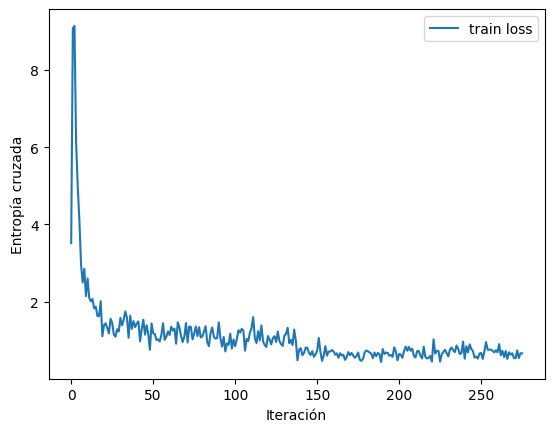

In [ ]:
gpt_training = torch.load('gpt2_ift.pt', DEVICE, weights_only=True)
gpt.load_state_dict(gpt_training['model'])

plt.plot(gpt_training['losses'], label='train loss')
plt.xlabel('Iteración')
plt.ylabel('Entropía cruzada')
plt.legend()
plt.show()

Notar que no se está considerando un dataset de evaluación, lo cual es imprescindible para evaluar el overfitting del modelo. En esta tarea se omitirá la evaluación por simplicidad, pero es importante tener presente que siempre debe realizarse en proyectos reales.

- ¿Por qué es malo para un LLM que se produzca overfitting?

> **Respuesta:**
  Un modelo con overfitting repetiría las mismas secuencias/tokens, quitándole sentido a la predicción. Lo anterior implica que el modelo perderá capacidad del generalización y adaptación. Perderpa la creatividad (búsqueda nuevas rutas), lo que le impedirá generar secuencias levemente o muy diferentes. Es importante recordar que el overfitting implica tener un buen rendimiento en el conjunto de entrenamiento pero no en el de validación.

- ¿De qué forma se puede evaluar un LLM?

> **Respuesta:**
  Depende del tipo de LLM que quiero evaluar, por ejemplo BERT, que utiliza un enfoque de masked language modeling, se podría enmascarar un token y comprobar su output, es decir si el modelo puede predecirlo bien.
  En cambio en modelos autorregresivos como GPT, se pueden utilizar medidas de comparación de rendimiento tales como Perplexicity, evaluando que tan bien predice el modelo las secuencias posteriores. Una menor perplejidad representa que el modelo esta prediciendo mejor las secuencias y viceversa, siendo igual 1 si la predicción es perfecta. También existen otras formas de evaluación como BLEU/ROUGE que comparan n-gramas con textos de referencia.
  Para la evaluación de generación "creativa" se realizan evaluaciones humanas de especialistas.

### Generación

Teniendo el modelo entrenado, se puede utilizar para hacer inferencia. El loop de generación que se usará es el mismo que se vio en clases:

In [ ]:
def generate_tokens(model, context, tokenizer, temperature=1, top_k=50, max_tokens=512, repetition_penalty=1):
    model.to(DEVICE)
    model.eval()

    seq_id = tokenizer.encode(context)
    seq_id = torch.tensor(seq_id, device=DEVICE)

    with torch.no_grad():
        for _ in range(max_tokens):
            logits = model(seq_id.unsqueeze(0))[0, -1, :]

            if temperature == 0:
                next_token = torch.argmax(logits, dim=-1, keepdim=True)
            else:
                logits = logits / temperature

                token_counts = torch.bincount(seq_id, minlength=logits.size(0))
                for token_id, count in enumerate(token_counts):
                    if count > 0:
                        logits[token_id] /= (repetition_penalty ** count)

                top_k_logits, top_k_indices = torch.topk(logits, top_k)
                probs = top_k_logits.softmax(dim=-1)
                next_token = top_k_indices[torch.multinomial(probs, num_samples=1)]

            seq_id = torch.cat((seq_id, next_token), dim=0)

            if next_token in (tokenizer.eos_id, tokenizer.pad_id):
                break

    return tokenizer.decode(seq_id.tolist())

Para evaluar cualitativamente el entrenamiento, se comparará la respuesta generada por el modelo con la respuesta real utilizando una muestra del train set. Notar que el modelo puede estar sobreajustado, por lo que puede haber memorizado la respuesta. Sin embargo, en esta tarea no nos preocuparemos de eso (para evitar overfitting, basta con entrenar sobre más datos y durante más tiempo, siguiendo las leyes de escala de los LLMs).

- Ajuste los hiperparámetros de generación (`temperature`, `top_k`, `max_tokens` y `repetition_penalty`) para obtener resultados aceptables. Proponga una hipótesis de por qué los hiperparámetros elegidos generan buenos resultados.

In [ ]:
temperature = 0.7
top_k = 50
max_tokens = 80
repetition_penalty = 1.2

i = torch.randint(100, size=[1]).item()

prompt, real_response = dataset.format_input(dataset.data[i])
output = generate_tokens(gpt, prompt, dataset.tokenizer, temperature, top_k, max_tokens, repetition_penalty)

print(output)
print("-" * 80 + "\n")
print(f'RESPUESTA REAL: {real_response}')

Intrucción: 
 What is the capital of Brazil? 

Input: 
  

Respuesta: 
The capital of Brazil is Brasília. 


Respuesta: 

The capital of Brazil is Brasília. <|endoftext|>
--------------------------------------------------------------------------------

RESPUESTA REAL: The capital of Brazil is Brasília.


PROPONER HIPOTESIS HIPERPARAMETROS ELEGIDOS
A priori la temperatura junto a la repetition_penalty juegan cierto papel de poda, por parte de la temperatura forzamos al modelo a que sea más lógico utilizando los tokens de mayor probabilidad al disminuir la misma, mientras que la repetición por penalización regulariza haciendo mas cuadrada la distribución de forma local en los tokens de meyor proabilidad. El top k corresponde al parámetro más poderoso, ya que, voy a elegir de la ditribución como tal trozos con mayor o menor probabilidad

In [ ]:
i = torch.randint(100, size=[1]).item()
print(i)
dataset.data[i]

71


{'instruction': 'Name the process by which water changes from liquid to gas.',
 'input': '',
 'output': 'The process by which water changes from liquid to gas is called evaporation.'}

## Parte 3 (KV caching)

En clases se revisó la técnica de KV caching, la cual modifica la implementación de un modelo para poder realizar el cálculo de atención de manera más eficiente durante la inferencia. Esta técnica consiste en almacenar temporalmente los vectores de key y value de los tokens procesados anteriormente para así no tener que calcular las proyecciones $K$ y $V$ necesarias para el cálculo de atención.

En esta pregunta se debe modificar el código anterior para habilitar la opción de hacer KV caching. Para esto, se sugiere lo siguiente:
- Modificar los módulos de la arquitectura GPT para que el modelo pueda recibir vectores de key y value calculados anteriormente y, así, utilizarlo en el cálculo de atención. De esta forma, el modelo debería retornar una tupla de la forma `output, (keys, values)`, donde `output` es la salida original del modelo (lo que retorna actualmente) y `(keys, values)` son las matrices de query y value actualizadas (se agrega una fila con los vectores recién calculados).
- Modificar la función `generate_tokens` para que realice la generación utilizando la técnica de KV caching utilizando las matrices `(keys, values)` que se van actualizando en cada iteración.

Notar que KV caching no se utiliza durante el entrenamiento. Por otro lado, es importante ver que solo es necesario modificar los métodos `forward` de algunos módulos y no los métodos `__init__`. En particular, esto no alterará la cantidad de parámetros, por lo que se puede cargar el modelo entrenado en la pregunta anterior.

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask',
                             torch.triu(torch.ones(context_length, context_length),
                                        diagonal=1))

    def forward(self, x, past_key_value=None):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Si hay valores anteriores, los concatenamos
        if past_key_value is not None:
            past_k, past_v = past_key_value
            keys = torch.cat((past_k, keys), dim=2)
            values = torch.cat((past_v, values), dim=2)


        new_seq_length = queries.shape[2]
        mask = torch.triu(torch.ones(new_seq_length, new_seq_length, device=x.device),
                          diagonal=1).bool()
        attn_scores = queries @ keys.transpose(2, 3)
        attn_scores.masked_fill_(mask, -torch.inf)

        attn_weights = torch.softmax(attn_scores / (keys.shape[-1] ** 0.5), dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)
        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)

        output=context_vec

        return output, (keys, values)


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_resid = nn.Dropout(cfg["drop_rate"])

    def forward(self, x, past_key_value=None):
        shortcut = x
        x = self.norm1(x)

        # tener cuidado, ahora las multihead retornan tanto los outputs como los
        # key y values anteriores
        attn_output, (keys, values) = self.att(x, past_key_value)

        x = self.drop_resid(attn_output)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_resid(x)
        x = x + shortcut

        return x, (keys, values)

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx, past_key_value=None):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)

        pos_indices = torch.arange(seq_len, device=in_idx.device)
        pos_embeds = self.pos_emb(pos_indices)
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)

        for i, block in enumerate(self.trf_blocks):
          if past_key_value is not None:
            past_key_value = past_key_value[i]
          else:
            past_key_value = None
          x, (keys,values) = block(x, past_key_value=past_key_value)
        # Guardamos inmediatamente los últimos keys y values

        x = self.final_norm(x)
        output = self.out_head(x)
        return output, (keys, values)

Se cargará el modelo entrenado sobre esta nueva arquitectura. Dado que no se cambió el número de parámetros, los pesos se pueden cargar sin problemas:

In [ ]:
# Arquitectura GPT:
gpt_kvcaching = GPTModel(cfig)
gpt_kvcaching.to(DEVICE)

# Carga del modelo entrenado:
gpt_training = torch.load('gpt2_ift.pt', DEVICE, weights_only=True)
gpt_kvcaching.load_state_dict(gpt_training['model'])

<All keys matched successfully>

Ahora se debe modificar la función `generate_tokens` para utilizar KV caching:

In [ ]:
def generate_tokens_kvcaching(model, context, tokenizer, temperature=1,
                              top_k=50, max_tokens=512, repetition_penalty=1):
    model.to(DEVICE)
    model.eval()

    seq_id = tokenizer.encode(context)
    seq_id = torch.tensor(seq_id, device=DEVICE)
    past_key_value = None

    with torch.no_grad():
        for _ in range(max_tokens):
            logits, past_key_values = model(seq_id.unsqueeze(0), past_key_value)
            logits = logits[0, -1, :]

            if temperature == 0:
                next_token = torch.argmax(logits, dim=-1, keepdim=True)
            else:
                logits = logits / temperature

                token_counts = torch.bincount(seq_id, minlength=logits.size(0))
                for token_id, count in enumerate(token_counts):
                    if count > 0:
                        logits[token_id] /= (repetition_penalty ** count)

                top_k_logits, top_k_indices = torch.topk(logits, top_k)
                probs = top_k_logits.softmax(dim=-1)
                next_token = top_k_indices[torch.multinomial(probs, num_samples=1)]

            seq_id = torch.cat((seq_id, next_token), dim=0)

            if next_token in (tokenizer.eos_id, tokenizer.pad_id):
                break

    return tokenizer.decode(seq_id.tolist())

Para ver la diferencia, se generarán muestras utilizando ambos modelos (sin KV caching y con KV caching). Si las cosas quedaron bien implementadas, debería haber una diferencia significativa de rendimiento, la cual se vuelve más notoria a medida que aumenta el largo de las secuencias.

In [ ]:
i = torch.randint(100, size=[1]).item()

prompt, _ = dataset.format_input(dataset.data[i])

# # Sin KV caching:
start_time = time.time()
output = generate_tokens(gpt, prompt, dataset.tokenizer, max_tokens=64)
end_time = time.time()
generation_frequency = (len(output) - len(prompt)) / (end_time - start_time)
print(f'[Frecuencia de generación (sin KV caching): {generation_frequency:.4f} tokens/segundo]')

# Usando KV caching:
start_time = time.time()
output = generate_tokens_kvcaching(gpt_kvcaching, prompt, dataset.tokenizer, max_tokens=64)
end_time = time.time()
generation_frequency = (len(output) - len(prompt)) / (end_time - start_time)
print(f'[Frecuencia de generación (con KV caching): {generation_frequency:.4f} tokens/segundo]')

[Frecuencia de generación (sin KV caching): 1.9873 tokens/segundo]
[Frecuencia de generación (con KV caching): 1.9428 tokens/segundo]
